In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.covariance import EllipticEnvelope
import collections
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

In [2]:
data = pd.read_csv('CSC215_P2_Stock_Price.csv')
#data.drop(['Date','Adj Close'], axis=1, inplace=True)
data

,Date,Open,High,Low,Close,Adj_Close,Volume
0,2000/3/27,3.812500,4.156250,3.812500,4.125000,4.125000,3675600
1,2000/3/28,4.125000,4.125000,4.000000,4.015625,4.015625,1077600
2,2000/3/29,4.000000,4.031250,3.953125,4.000000,4.000000,437200
3,2000/3/30,4.000000,4.000000,3.843750,3.843750,3.843750,1883600
4,2000/3/31,3.734375,3.734375,3.390625,3.390625,3.390625,7931600
...,...,...,...,...,...,...,...
4387,2017/9/1,113.790001,114.099998,112.790001,113.309998,113.309998,950000
4388,2017/9/5,112.519997,113.529999,111.160004,111.870003,111.870003,1805200
4389,2017/9/6,112.029999,112.489998,110.250000,112.230003,112.230003,2136700
4390,2017/9/7,112.459999,112.900002,112.000000,112.339996,112.339996,1251600


In [3]:
data.drop(['Date','Adj_Close'], axis=1, inplace=True)

In [4]:
data['y'] = data['Close']
data

,Open,High,Low,Close,Volume,y
0,3.812500,4.156250,3.812500,4.125000,3675600,4.125000
1,4.125000,4.125000,4.000000,4.015625,1077600,4.015625
2,4.000000,4.031250,3.953125,4.000000,437200,4.000000
3,4.000000,4.000000,3.843750,3.843750,1883600,3.843750
4,3.734375,3.734375,3.390625,3.390625,7931600,3.390625
...,...,...,...,...,...,...
4387,113.790001,114.099998,112.790001,113.309998,950000,113.309998
4388,112.519997,113.529999,111.160004,111.870003,1805200,111.870003
4389,112.029999,112.489998,110.250000,112.230003,2136700,112.230003
4390,112.459999,112.900002,112.000000,112.339996,1251600,112.339996


In [5]:
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

In [6]:
def to_sequences(seq_size, data1, data2):
    x = []
    y = []

    for i in range(len(data1)-seq_size):
        #print(i)
        window = data1[i:(i+seq_size)]
        after_window = data2[i+seq_size]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x), np.array(y)

In [7]:
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd

In [8]:
encode_numeric_zscore(data,'Open')
encode_numeric_zscore(data,'High')
encode_numeric_zscore(data,'Low')
encode_numeric_zscore(data,'Close')
#encode_numeric_zscore(dataFrame,'Adj Close')
encode_numeric_zscore(data,'Volume')

In [9]:
y = data[['y']].copy()
x = data.drop(['y'], axis = 1)

In [10]:
x = np.array(x, dtype=np.float32)
y = np.array(data['y'].values, dtype=np.float32)

In [11]:
x.shape,y.shape

((4392, 5), (4392,))

In [12]:
SEQUENCE_SIZE = 7

x_LSTM,y_LSTM = to_sequences(SEQUENCE_SIZE,x,y)

In [13]:
x_LSTM.shape,y_LSTM.shape

((4385, 7, 1, 5), (4385,))

In [14]:
x_LSTM=x_LSTM.reshape(4385,35)

In [15]:
x_LSTM.shape,y_LSTM.shape

((4385, 35), (4385,))

In [16]:
#x_cnn,y_cnn =to_sequences(SEQUENCE_SIZE,x,y)
x_train, x_test, y_train, y_test = train_test_split(x_LSTM, y_LSTM, test_size=0.25, random_state=33)

In [17]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((3288, 35), (1097, 35), (3288,), (1097,))

In [18]:
#x_train=x_train.reshape(3288,35)

In [25]:
model = Sequential()
model.add(Dense(64, input_dim=35, activation='relu'))
model.add(Dense(10,activation='relu'))
#model.add(Dense(5,activation='relu'))
model.add(Dense(1))

In [26]:
model.compile(loss='mean_squared_error', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=1, mode='auto')

checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True) # save best model

model.fit(x_train, y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=1000)

model.load_weights('best_weights.hdf5')

Train on 3288 samples, validate on 1097 samples
Epoch 1/1000
3288/3288 - 1s - loss: 1040.8237 - val_loss: 206.3748
Epoch 2/1000
3288/3288 - 0s - loss: 170.6553 - val_loss: 162.1047
Epoch 3/1000
3288/3288 - 0s - loss: 149.2091 - val_loss: 140.6340
Epoch 4/1000
3288/3288 - 0s - loss: 121.9677 - val_loss: 106.4058
Epoch 5/1000
3288/3288 - 0s - loss: 80.8917 - val_loss: 66.7843
Epoch 6/1000
3288/3288 - 0s - loss: 44.5733 - val_loss: 36.7306
Epoch 7/1000
3288/3288 - 0s - loss: 19.3951 - val_loss: 16.7013
Epoch 8/1000
3288/3288 - 0s - loss: 7.5876 - val_loss: 9.4281
Epoch 9/1000
3288/3288 - 0s - loss: 3.7896 - val_loss: 6.2294
Epoch 10/1000
3288/3288 - 0s - loss: 2.4206 - val_loss: 5.2579
Epoch 11/1000
3288/3288 - 0s - loss: 1.8943 - val_loss: 3.5587
Epoch 12/1000
3288/3288 - 0s - loss: 1.6584 - val_loss: 3.1611
Epoch 13/1000
3288/3288 - 0s - loss: 1.3699 - val_loss: 2.7940
Epoch 14/1000
3288/3288 - 0s - loss: 1.3257 - val_loss: 2.6440
Epoch 15/1000
3288/3288 - 0s - loss: 1.1884 - val_loss: 

Score_train (RMSE): 0.9783825278282166
Score_test (RMSE): 1.436767578125


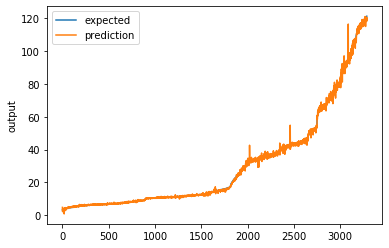

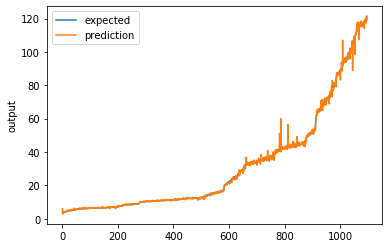

In [28]:
from sklearn import metrics

pred_train = model.predict(x_train)
score_train = np.sqrt(metrics.mean_squared_error(pred_train,y_train))
print("Score_train (RMSE): {}".format(score_train))

pred_test = model.predict(x_test)
score_test = np.sqrt(metrics.mean_squared_error(pred_test,y_test))
print("Score_test (RMSE): {}".format(score_test))

#chart_regression(pred.flatten(),y_lstm_seq_test, sort=True)
chart_regression(pred_train.flatten(),y_train, sort=True)
chart_regression(pred_test.flatten(),y_test, sort=True)